In [1]:
import numpy as np
import pandas as pd
import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import linear_model, preprocessing
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error


#### Global

##### These variables affect all models

In [2]:
testPercent = 0.1 #10% training
predictorColumn = "balance"

###### Time Series and Regression don't play nicely together so we're going to essentially run two seperate ensembles models then combine them at the very end

In [3]:
# import transaction data
def read_transaction_by_Q(q):
    transactions = pd.read_csv(q+'.csv')
    transactions = transactions.sort_values(by="postDate")
    # reset the index
    transactions = transactions.reset_index(drop=True)
    return transactions

In [4]:
# ADDING NEW TOTAL BALANCE COLUMN
def process_transactions(transactions, columns_to_keep):

    # Get initial balance with the first 'balance' value
    initial_balance = transactions.at[0, 'balance']
    # Set the 'total_balance' of the first row to be the initial balance
    transactions.at[0, 'total_balance'] = initial_balance
    # Iterate through each row in transactions starting from the second row (index 1)
    for index, row in transactions.iterrows():
        if index == 0:
            continue  # Skip the first row since we already set the initial balance
        amount = row['amount']
        # calculate the running balance across all accounts
        initial_balance += amount
        # update the 'total_balance' column
        transactions.at[index, 'total_balance'] = initial_balance

    # Insert the 'total_balance' column at the specified position
    transactions.insert(7, 'total_balance', transactions.pop('total_balance'))

    #Drop unnecessary cols
    transactions = transactions[['amount', 'total_balance', 'postDate']]

    try:
        transactions['postDate'] = pd.to_datetime(transactions['postDate'])
        # Set the 'postDate' column as the index
        return transactions[columns_to_keep]
    except ValueError:
        print("Error: 'postDate' column could not be converted to datetime format.")
        return None

transactions = process_transactions(read_transaction_by_Q('user1'), ['postDate', 'total_balance', 'amount'])
transactions

<ipython-input-4-9d19643f8216>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['postDate'] = pd.to_datetime(transactions['postDate'])


,postDate,total_balance,amount
0,2021-04-30 00:00:00+00:00,-360275.00,4040.00
1,2021-04-30 00:00:00+00:00,-364315.00,-4040.00
2,2021-05-14 00:00:00+00:00,-364815.00,-500.00
3,2021-05-15 00:00:00+00:00,-364614.00,201.00
4,2021-05-19 00:00:00+00:00,-368116.50,-3502.50
...,...,...,...
495,2023-11-14 00:00:00+00:00,-338793.86,-2.50
496,2023-11-14 00:00:00+00:00,-339293.86,-500.00
497,2023-11-14 00:00:00+00:00,-339296.36,-2.50
498,2023-11-16 00:00:00+00:00,-343084.61,-3788.25


In [6]:
from scipy import stats
def group_data(transactions, option = 1 ): # Set the 'postDate' column as the index
    timeseries_grouped = pd.DataFrame()
    if option == 1:
        timeseries_grouped = transactions.groupby('postDate')[['amount','total_balance']].mean()
    elif option == 2:
        timeseries_grouped = transactions.groupby('postDate')[['amount','total_balance']].min()
    elif option == 3:
        timeseries_grouped = transactions.groupby('postDate')[['amount','total_balance']].max()
    else:
        timeseries_grouped = transactions.groupby('postDate')[['amount','total_balance']].sum()

    # Calculate summary statistics
    mean_balance = timeseries_grouped['total_balance'].mean()
    median_balance = timeseries_grouped['total_balance'].median()
    std_balance = timeseries_grouped['total_balance'].std()

    print(f"Mean Balance: {mean_balance}")
    print(f"Median Balance: {median_balance}")
    print(f"Standard Deviation of Balance: {std_balance}")

    z_scores = np.abs(stats.zscore(timeseries_grouped['total_balance']))
    threshold = 3  # Adjust the threshold as needed
    outliers_indices = np.where(z_scores > threshold)[0]

    # Get the actual outlier values
    outlier_values = timeseries_grouped['total_balance'].iloc[outliers_indices]

    print("Indices of outliers:", outliers_indices)
    print("Outlier values:", outlier_values)
    print('-----------------------------------------')
    return timeseries_grouped

In [7]:
# visualise time series
import matplotlib.pyplot as plt
def plot_transactions(transactions, q):
    plt.figure(figsize=(12, 6))
    plt.plot(transactions['total_balance'])
    plt.title('Time Series Plot of Balance for ' + q)
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey-Fuller (ADF) test to check for stationarity
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
    #  print("1. ADF : ",dftest[0])
    #  print("2. P-Value : ", dftest[1])
    #  print("3. Num Of Lags : ", dftest[2])
    #  print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
    #  print("5. Critical Values :")
    #  for key, val in dftest[4].items():
    #      print("\t",key, ": ", val)
     if (dftest[1] > 0.05):
        print("Data is not stationary") #if p>0.05; Data is not stationary
     else:
        print("Data is stationary")

In [12]:
ad_test(transactions['total_balance'])

Data is not stationary


In [10]:
#Read Q data
def read_process_Q_data(Q, plot, option):
    Q_data = read_transaction_by_Q(Q)
    Q_data_processed = process_transactions(Q_data)
    if Q_data_processed is not None:
        Q_data_grouped = group_data(Q_data_processed, option=option)
        if plot:
            plot_transactions(Q_data_grouped, '' + Q + ' - Mean')
    return Q_data_grouped

In [51]:
def combine_all_Q(Q, option):
    All_Q_data = []
    for q in Q:
        print('For ' + q)
        Q_data = read_process_Q_data(q, plot = False, option = option)
        All_Q_data.append(Q_data)
        ad_test(Q_data['total_balance'])
    # Vertically stack the DataFrames
    print('For All Qs ')
    Q_data_combined = pd.concat(All_Q_data)
    ad_test(Q_data_combined['total_balance'])
    return Q_data_combined

## **START SARIMAX**

In [52]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.9 MB/s eta 0:00:00


In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima  # For automatic hyperparameter tuning

In [54]:
# Use AutoARIMA for hyperparameter tuning
autoarima_model = auto_arima(Q_data_combined['total_balance'], seasonal=True, stepwise=True, suppress_warnings=True)
# Get the best orders
best_order = autoarima_model.order
best_seasonal_order = autoarima_model.seasonal_order
print(f'Best Order: {best_order}')
print(f'Best Seasonal Order: {best_seasonal_order}')

NameError: ignored

<b> Best Order: (2, 0, 0) </b>
<br>
The order parameter represents the non-seasonal (p, d, q) components of the SARIMA model:
* p (autoregressive order): 2
* d (degree of differencing): 0
* q (moving average order): 0
* The two most recent observations and no differencing in the non-seasonal part of the model provides the best fit.
<br>

<b> Best Seasonal Order: (0, 0, 0, 0) </b> <br>
The seasonal_order parameter represents the seasonal (P, D, Q, S) components of the SARIMA model:
* P (seasonal autoregressive order): 0
* D (seasonal degree of differencing): 0
* Q (seasonal moving average order): 0
* S (seasonal period): 0 (non-seasonal)
* The model does not require any specific seasonal components, as the best fit is achieved with a non-seasonal model.


In [ ]:
#Apply Differencing
def apply_differencing(df, d): # Determine the order of differencing needed to make the time series stationary
    # Apply differencing
    df_diff = df.diff(periods=d).dropna()
    return df_diff


In [ ]:
# Function to fit ARIMA model and make predictions
def arima_forecast(df, df_train, df_test, order, seasonal_order, print_eval = False):

    # Fit the SARIMAX model with tuned parameters
    model_diff = SARIMAX(df_train['total_balance'], order=order, seasonal_order=seasonal_order)
    results_diff = model_diff.fit()
    aic = results_diff.aic
    # Forecast future values
    forecast_start_date = df_test.index[0]
    forecast_end_date_1mo = forecast_start_date + timedelta(days=30)
    forecast_end_date_3mo = forecast_start_date + timedelta(days=90)
    forecast_end_date_6mo = forecast_start_date + timedelta(days=180)

    forecast_1mo_diff = results_diff.get_forecast(steps=30)
    forecast_3mo_diff = results_diff.get_forecast(steps=90)
    forecast_6mo_diff = results_diff.get_forecast(steps=len(df_test))

    # Invert differencing to get predictions in the original scale
    pred_1mo = df['total_balance'].iloc[-1] + np.cumsum(forecast_1mo_diff.predicted_mean)
    pred_3mo = df['total_balance'].iloc[-1] + np.cumsum(forecast_3mo_diff.predicted_mean)
    pred_6mo = df['total_balance'].iloc[-1] + np.cumsum(forecast_6mo_diff.predicted_mean)

    # Extract the true values for the testing set
    true_values_1mo = df['total_balance'].loc[df_test.index[:30]]
    true_values_3mo = df['total_balance'].loc[df_test.index[:90]]
    true_values_6mo = df['total_balance'].loc[df_test.index]

    # Calculate metrics
    mae_1mo = mean_absolute_error(true_values_1mo, pred_1mo)
    mae_3mo = mean_absolute_error(true_values_3mo, pred_3mo)
    mae_6mo = mean_absolute_error(true_values_6mo, pred_6mo)

    mse_1mo = mean_squared_error(true_values_1mo, pred_1mo)
    mse_3mo = mean_squared_error(true_values_3mo, pred_3mo)
    mse_6mo = mean_squared_error(true_values_6mo, pred_6mo)

    rmse_1mo = np.sqrt(mse_1mo)
    rmse_3mo = np.sqrt(mse_3mo)
    rmse_6mo = np.sqrt(mse_6mo)

    if print_eval:
        print(f'MAE (1-month): {mae_1mo:.2f}')
        print(f'MAE (3-months): {mae_3mo:.2f}')
        print(f'MAE (6-months): {mae_6mo:.2f}')
        print(f'RMSE (1-month): {rmse_1mo:.2f}')
        print(f'RMSE (3-months): {rmse_3mo:.2f}')
        print(f'RMSE (6-months): {rmse_6mo:.2f}')


    return [aic, true_values_1mo, pred_1mo,true_values_3mo, pred_3mo,true_values_6mo, pred_6mo]


In [ ]:
option = 4  #mean: 1 , max:2, min: 3 , sum: 4
Q = ['Q1','Q2','Q3','Q4']
Q_data_combined = combine_all_Q(Q, option)
#plot_transactions(Q_data_combined, q = 'All Q')

For Q1
Mean Balance: -6262.503636363621
Median Balance: -6777.289999999997
Standard Deviation of Balance: 26820.700098321493
Indices of outliers: [50 75]
Outlier values: postDate
2022-02-28 00:00:00+00:00   -89784.84
2022-03-30 00:00:00+00:00    78612.18
Name: total_balance, dtype: float64
-----------------------------------------
Data is stationary
For Q2
Mean Balance: -11637.125443037974
Median Balance: -4149.79
Standard Deviation of Balance: 28754.548292884112
Indices of outliers: [15]
Outlier values: postDate
2022-04-19 00:00:00+00:00   -140416.95
Name: total_balance, dtype: float64
-----------------------------------------
Data is stationary
For Q3
Mean Balance: -35363.383124999986
Median Balance: -26901.799999999996
Standard Deviation of Balance: 29436.01645558764
Indices of outliers: [23 47]
Outlier values: postDate
2022-07-26 00:00:00+00:00   -154723.78
2022-08-25 00:00:00+00:00   -138347.95
Name: total_balance, dtype: float64
-----------------------------------------
Data is s

In [ ]:
# Run this code in a specific cell to suppress warnings in that cell
import warnings
warnings.filterwarnings('ignore')

d = 1
#Apply Differencing
df_diff = apply_differencing(Q_data_combined, d = d)
[len(df_diff), len(Q_data_combined)]
# #update global vars
testPercent = 0.4 #10% testing
predictorColumn = "total_balance"

split_idx = int((1-testPercent) * len(df_diff))
train_data_timeseries = df_diff.iloc[:split_idx]
test_data_timeseries = df_diff.iloc[split_idx:]
print(f'Train set length = {len(train_data_timeseries)}')
print(f'Test set length = {len(test_data_timeseries)}')

Train set length = 175
Test set length = 118


In [ ]:
import itertools
import statsmodels.api as sm

# Example ranges for p, d, q
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)

# Create a list of all possible combinations of p, d, q
order_combinations = list(itertools.product(p_range, d_range, q_range))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p_range, d_range, q_range))]


# Perform grid search
best_aic = float('inf')
best_order = None
best_seasonal_order = None

for order in order_combinations:
    for seasonal_order in seasonal_pdq:
        try:
            seasonal_order = (1, 1, 1, 12)  # Example seasonal order (P, D, Q, S)
            [aic, true_values_1mo, pred_1mo,true_values_3mo, pred_3mo,true_values_6mo, pred_6mo] = \
                arima_forecast(Q_data_combined, train_data_timeseries, test_data_timeseries, order, seasonal_order)
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

print(f'Best AIC: {best_aic}')
print(f'Best Order: {best_order}')
print(f'Best Seasonal Order: {best_seasonal_order}')

[aic, true_values_1mo, pred_1mo,true_values_3mo, pred_3mo,true_values_6mo, pred_6mo] = \
            arima_forecast(Q_data_combined, train_data_timeseries, test_data_timeseries, best_order, best_seasonal_order, print_eval = True)

#AIC stands for Akaike Information Criterion. It is a metric used for model selection,
# particularly in the context of time series analysis and other statistical modeling.
# AIC quantifies the trade-off between the goodness of fit of the model and the simplicity of the model.
# The goal is to find a model that fits the data well but is not too complex.


Best AIC: 3786.7431942482854
Best Order: (1, 0, 1)
Best Seasonal Order: (1, 1, 1, 12)
MAE (1-month): 85786.06
MAE (3-months): 64262.56
MAE (6-months): 55491.30
RMSE (1-month): 94704.95
RMSE (3-months): 75483.67
RMSE (6-months): 68674.80


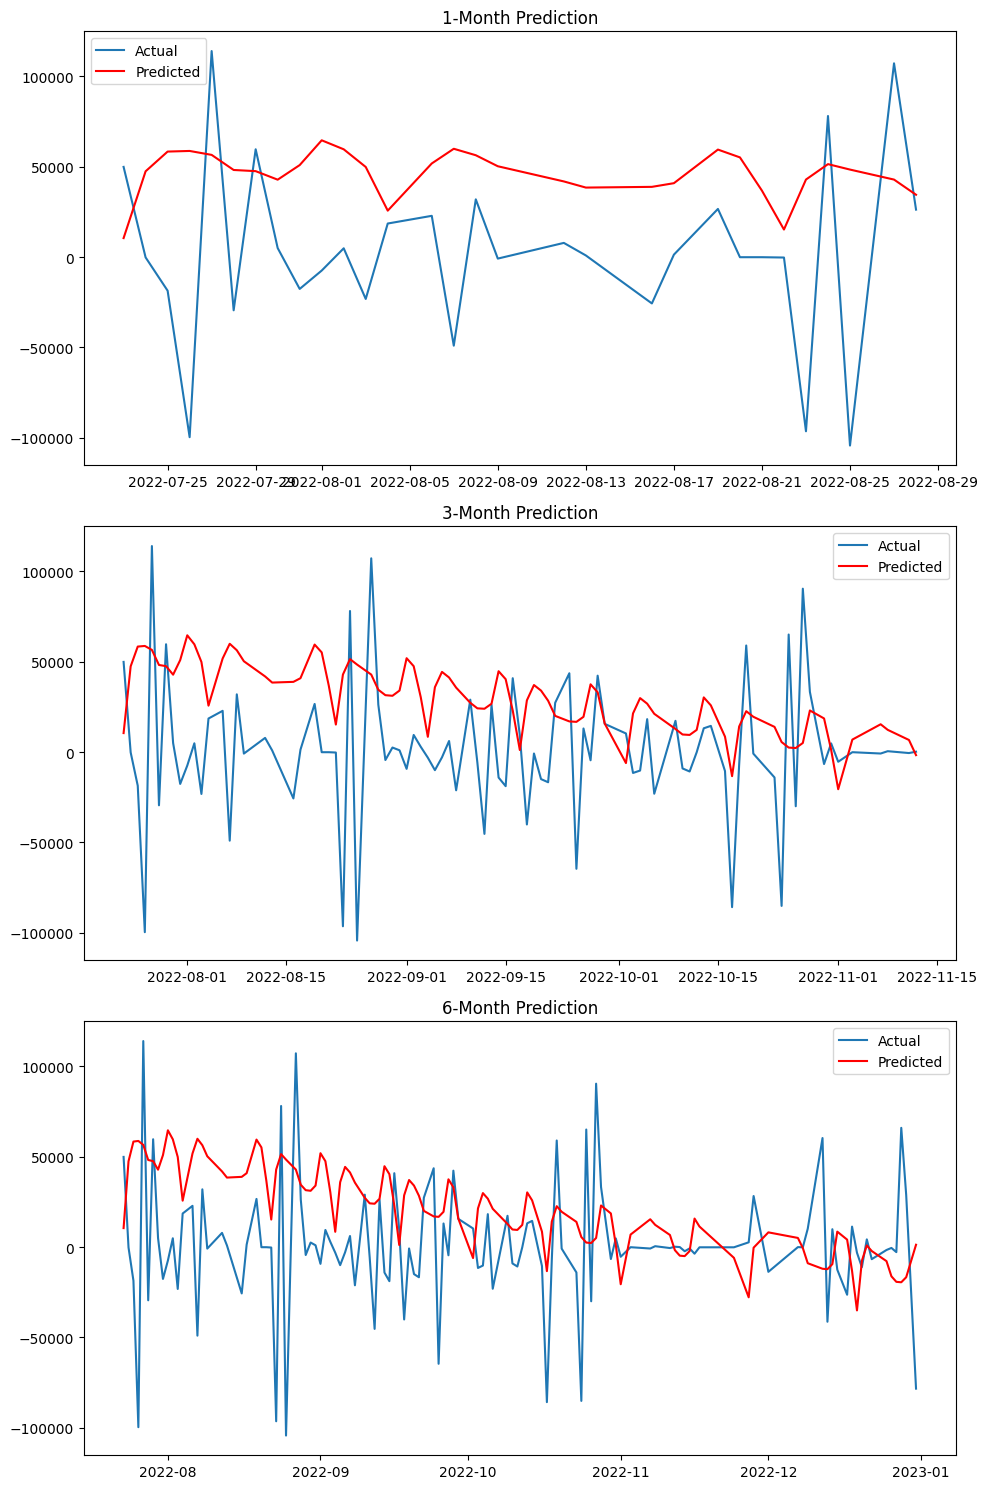

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have pred_1mo, pred_3mo, and pred_6mo from your previous code

# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot 1-month predictions
axes[0].plot(test_data_timeseries.index[:30], test_data_timeseries['total_balance'][:30], label='Actual')
axes[0].plot(test_data_timeseries.index[:30], pred_1mo, color='red', label='Predicted')
axes[0].set_title('1-Month Prediction')
axes[0].legend()

# Plot 3-month predictions
axes[1].plot(test_data_timeseries.index[:90], test_data_timeseries['total_balance'][:90], label='Actual')
axes[1].plot(test_data_timeseries.index[:90], pred_3mo, color='red', label='Predicted')
axes[1].set_title('3-Month Prediction')
axes[1].legend()

# Plot 6-month predictions
axes[2].plot(test_data_timeseries.index, test_data_timeseries['total_balance'], label='Actual')
axes[2].plot(test_data_timeseries.index, pred_6mo, color='red', label='Predicted')
axes[2].set_title('6-Month Prediction')
axes[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Regression Section

In [ ]:
def encode_data_class(df):
    #Keep the category
    labelEnc = preprocessing.LabelEncoder()
    df['subClass.title'] = labelEnc.fit_transform(df['subClass.title'])

    #Drop unnecessary
    numeric_columns = df.select_dtypes(include='number').columns
    df = df[numeric_columns]
    #Remove NaN
    df = df.dropna(axis=1)
    return df

In [ ]:

# Run this code in a specific cell to suppress warnings in that cell
import warnings
warnings.filterwarnings('ignore')


Q = ['Q1','Q2','Q3','Q4']
All_Q_data = []
for q in Q:
    Q_data = read_transaction_by_Q(q)
    Q_data_processed = encode_data_class(process_transactions(Q_data))
    All_Q_data.append(Q_data_processed)

Q_data_combined = pd.concat(All_Q_data)
print(Q_data_combined.head())

#cheack stationarity
ad_test(Q_data_combined['total_balance'])

   amount  total_balance  subClass.title
0 -114.40        -152.50              34
1 -326.01        -478.51              11
2  -10.04        -488.55              34
3 -131.00        -619.55               0
4  -70.00        -689.55               5
Data is stationary


In [ ]:
from sklearn.model_selection import train_test_split

d = 1
#Apply Differencing
df_diff = apply_differencing(Q_data_combined, d = d)
[len(df_diff), len(Q_data_combined)]
# #update global vars
testPercent = 0.3 #10% testing
predictorColumn = "total_balance"

# Split the data into features (X) and target variable (y)
X_data = df_diff.drop('total_balance', axis=1)
y_data = df_diff['total_balance']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=testPercent, shuffle=False)

print(f'Train set length = {len(X_train)}')
print(f'Test set length = {len(X_test)}')


Train set length = 893
Test set length = 384


MAE: 244.29
MSE: 1117271.44
RMSE: 1057.01


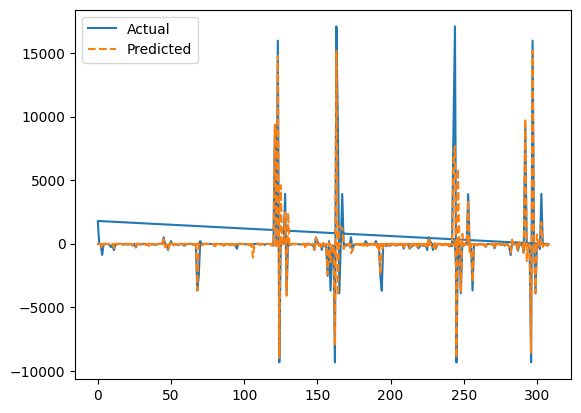

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

# Plotting actual vs predicted values
plt.plot(df_diff.index[-len(y_test):], y_test, label='Actual')
plt.plot(df_diff.index[-len(y_test):], y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.show()


### Final Combination

In [ ]:
#TODO